<a id="read"></a>
# <p style=" background-color: white; font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Traffic Sign Recognition Using CNN</p>
## Contributors:
- Contributor 1: Mouna Chtourou
- Contributor 2: Roua Ben Amna
- Contributor 3: Mohmaed Amara
- Contributor 4: Maram Mekni

3 IDL 1, School Year 2024-2025


<a id="contents_tabel"></a>    
<div style="border-radius:10px; padding: 15px; font-size:115%; text-align:left">

<h3 align="left" style="color: black;">Table of Contents:</h3>

<ul style="list-style-type: none; padding-left: 0;">
  <li><a href="#import" style="color: black; text-decoration: none;">Step 1 | Import Libraries</a></li>
      <li><a href="#preprocessing" style="color: black; text-decoration: none;">Step 2 | Data Preprocessing</a>
    <ul style="list-style-type: none; padding-left: 20px;">
      <li><a href="#blurry" style="color: black; text-decoration: none;">Step 2.1 | Image Blurriness Detection and Sharpening</a></li>
      <li><a href="#dark" style="color: black; text-decoration: none;">Step 2.2 | Enhancing Dark Images</a></li>
      <li><a href="#crop" style="color: black; text-decoration: none;">Step 2.3 | Image Detection, Cropping, Resizing, and Visualization with Bounding Boxes</a></li>
    <li><a href="#reshape" style="color: black; text-decoration: none;">Step 2.4 | Reshaping Features for the CNN model </a></li>
    <li><a href="#augmentation" style="color: black; text-decoration: none;">Step 2.5 | Data Augmentation </a></li>
    </ul>
     <li><a href="#eda" style="color: black; text-decoration: none;">Step 3 | Exploratory Data Analysis</a></li>
  </li>
  <li><a href="#model" style="color: black; text-decoration: none;">Step 4 | Model Definition</a>
    <ul style="list-style-type: none; padding-left: 20px;">
      <li><a href="#architecture" style="color: black; text-decoration: none;">Step 4.1 | Define Architecture</a></li>
      <li><a href="#compilation" style="color: black; text-decoration: none;">Step 4.2 | Compile Model</a></li>
    </ul>
  </li>
  <li><a href="#training" style="color: black; text-decoration: none;">Step 5 | Training and Validation</a></li>
  <li><a href="#evaluation" style="color: black; text-decoration: none;">Step 6 | Evaluation</a>
    <ul style="list-style-type: none; padding-left: 20px;">
      <li><a href="#confusion-matrix" style="color: black; text-decoration: none;">Step 6.1 | Confusion Matrix</a></li>
      <li><a href="#performance-metrics" style="color: black; text-decoration: none;">Step 6.2 | Performance Metrics</a></li>
    </ul>
  </li>
  <li><a href="#serialization" style="color: black; text-decoration: none;">Step 7 | Model Serialization</a></li>
  <li><a href="#inference" style="color: black; text-decoration: none;">Step 8 | Inference</a></li>
</ul>
</div>

<a id="import"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 1 | Import Libraries</p>

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.callbacks import TensorBoard

<a id="preprocessing"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 2 | Data Preprocessing</p>

<a id="blurry"></a>
# <b><span style='color: black; font-size: 80%;'>Step 2.1 |</span><span style='color: black; font-size: 80%;'> Image Blurriness Detection and Sharpening</span></b>

In [7]:
def is_blurry(image, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return variance < threshold

def sharpen_image(image):
    kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

<a id="dark"></a>
# <b><span style='color: black; font-size: 80%;'>Step 2.2 |</span><span style='color: black; font-size: 80%;'> Enhancing Dark Images</span></b>

In [9]:
import cv2
import numpy as np
from PIL import ImageEnhance

def enhance_dark_image(image):
    """
    Enhance images that are too dark using adaptive histogram equalization and brightness adjustment,
    with noise reduction to avoid amplifying noise.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)

    if mean_brightness < 60: 
        image = cv2.GaussianBlur(image, (5, 5), 0)

        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(image_lab)

        l = clahe.apply(l)
        enhanced_image_lab = cv2.merge((l, a, b))
        image = cv2.cvtColor(enhanced_image_lab, cv2.COLOR_LAB2RGB)

        pil_image = Image.fromarray(image)
        enhancer = ImageEnhance.Brightness(pil_image)
        brightness_factor = 1 + (60 - mean_brightness) / 100.0  
        image = np.array(enhancer.enhance(brightness_factor)) 

    return image

<a id="crop"></a>
# <b><span style='color: black; font-size: 80%;'>Step 2.3 |</span><span style='color: black; font-size: 80%;'> Image Detection, Cropping, Resizing, and Visualization with Bounding Boxes
</span></b>

Image 00000_00002_00000_png.rf.3f5868e97a26b188b4d3ce823c6e9c2f.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.3cef739224527428e387081193bd420b.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.b3a05eda45b885ae1a472c7547721760.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.02a1b30e881b936472e3872b5e7cf3b0.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.2df6f5515035d2e03ba24ec9e622753a.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.98523532781dd4a1df08bbddeef993ad.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.dbd1e2336ba48e0575fb5b91b48e6af8.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.42fa00c6a4d5575600e9de72a47bb7a4.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.a628aaae48b8d9635585e79879bd2788.jpg is blurry, sharpening...
Image 00000_00002_00005_png.rf.4a27eb57929561fce8d7295d6e5a02d4.jpg is blurry, sharpening...
Image 00000_00002_00006_png.rf.5cf10a07acd232b133e564cc9f0b058b.jpg is

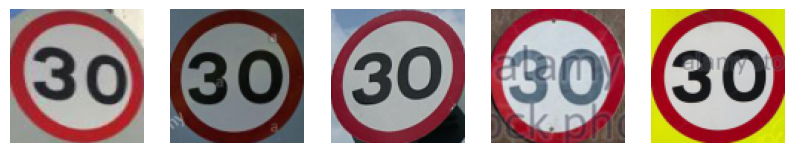

In [11]:
def fetch_image_with_detection_and_visualization(data_folder):
    """
    Fetch images and corresponding labels, perform detection (crop based on bounding boxes),
    and resize to fit the classifier's input. Also visualizes a sample cropped image.
    """
    train_data = []
    test_data = []
    valid_data = []
    cropped_samples = [] 

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            img = Image.open(image_path)
            image_width, image_height = img.size
            img = np.array(img)
            
            img = enhance_dark_image(img)

            if is_blurry(img):
                print(f"Image {image_name} is blurry, sharpening...")
                img = sharpen_image(img)

            with open(label_path, "r") as label_file:
                lines = label_file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0]) 

                    x_center, y_center, width, height = map(float, parts[1:])

                    x_min = int((x_center - width / 2) * image_width)
                    y_min = int((y_center - height / 2) * image_height)
                    x_max = int((x_center + width / 2) * image_width)
                    y_max = int((y_center + height / 2) * image_height)

                    cropped_img = img[y_min:y_max, x_min:x_max]

                    resized_img = cv2.resize(cropped_img, (90, 90), interpolation=cv2.INTER_AREA)

                    resized_img = resized_img / 255.0

                    if len(cropped_samples) < 5: 
                        cropped_samples.append(resized_img)

                    if split_name == "train":
                        train_data.append((resized_img, class_id))
                    elif split_name == "test":
                        test_data.append((resized_img, class_id))
                    elif split_name == "valid":
                        valid_data.append((resized_img, class_id))

    if cropped_samples:
        plt.figure(figsize=(10, 10))
        for i, cropped_img in enumerate(cropped_samples):
            plt.subplot(1, len(cropped_samples), i+1)
            plt.imshow(cropped_img)
            plt.axis('off')
        plt.show()

    return train_data, test_data, valid_data
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image_with_detection_and_visualization(data_folder)

<a id="reshape"></a>
# <b><span style='color: black; font-size: 80%;'>Step 2.4 |</span><span style='color: black; font-size: 80%;'> Reshaping Features for the CNN model
</span></b>

In [13]:
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features).reshape(-1, 90, 90, 3) 
training_data_labels = np.array(training_data_labels)

validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features).reshape(-1, 90, 90, 3)
validation_data_labels = np.array(validation_data_labels)

test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features).reshape(-1, 90, 90, 3)
test_data_labels = np.array(test_data_labels)

In [14]:
print(f"Training data features shape: {np.array(training_data_features).shape}")
print(f"Training data labels shape: {np.array(training_data_labels).shape}")

Training data features shape: (4298, 90, 90, 3)
Training data labels shape: (4298,)


In [15]:
unique_labels, label_counts = np.unique(training_data_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

Label 0: 542 occurrences
Label 1: 585 occurrences
Label 2: 19 occurrences
Label 3: 267 occurrences
Label 4: 101 occurrences
Label 5: 252 occurrences
Label 6: 285 occurrences
Label 7: 334 occurrences
Label 8: 235 occurrences
Label 9: 283 occurrences
Label 10: 301 occurrences
Label 11: 318 occurrences
Label 12: 323 occurrences
Label 13: 168 occurrences
Label 14: 285 occurrences


<a id="augmentation"></a>
# <b><span style='color: black; font-size: 80%;'>Step 2.5 |</span><span style='color: black; font-size: 80%;'> Data Augmentation </span></b>

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=45, 
    horizontal_flip=False,
    vertical_flip=False
)

# Fit the generator
datagen.fit(training_data_features)

<a id="eda"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 3 | Exploratory Data Analysis</p>

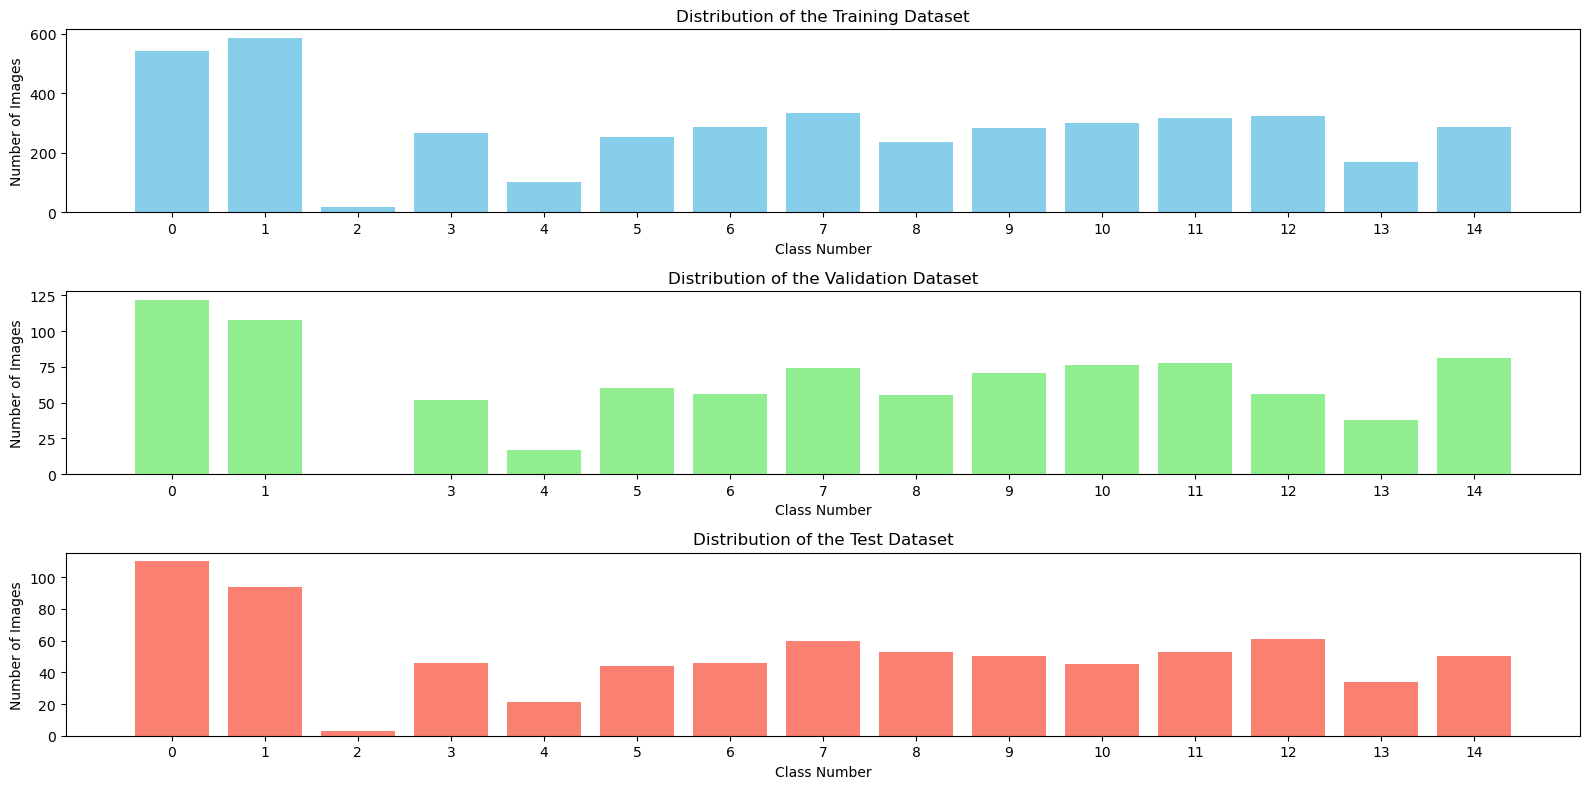

In [19]:
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

plt.figure(figsize=(16, 8))

plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

plt.tight_layout()
plt.show()

<a id="model"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 4 | Model Definition</p>

<a id="architecture"></a>
# <b><span style='color: black; font-size: 80%;'>Step 4.1 |</span><span style='color: black; font-size: 80%;'> Define Architecture </span></b>

In [22]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 3), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(15, activation='softmax'))

C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(4298, 90, 90, 16)


In [23]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 90, 90, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 232)                 │       1,069,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 116)                 │          27,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,555,959 (5.94 MB)

 Trainable params: 1,555,959 (5.94 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
from tensorflow.keras.utils import plot_model
plot_model(cnnModel, to_file="model.png", show_shapes=True, show_layer_names=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/", histogram_freq=1)

<a id="compilation"></a>
# <b><span style='color: black; font-size: 80%;'>Step 4.2 |</span><span style='color: black; font-size: 80%;'> Compile Model </span></b>

In [27]:
cnnModel.compile(optimizer='adam', 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 metrics=['accuracy'])

<a id="training"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 5 | Training and Validation</p>

In [29]:
SignTraffic = cnnModel.fit(
    datagen.flow(training_data_features, training_data_labels, batch_size=32),
    validation_data=(validation_data_features, validation_data_labels),
    epochs=20,
    callbacks=[tensorboard_callback]
)

C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.2097 - loss: 2.4165 - val_accuracy: 0.3856 - val_loss: 1.7301
Epoch 2/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.3858 - loss: 1.7323 - val_accuracy: 0.4703 - val_loss: 1.5672
Epoch 3/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.4603 - loss: 1.6076 - val_accuracy: 0.5689 - val_loss: 1.3109
Epoch 4/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.5736 - loss: 1.2701 - val_accuracy: 0.7013 - val_loss: 0.8673
Epoch 5/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.7156 - loss: 0.8680 - val_accuracy: 0.8517 - val_loss: 0.5174
Epoch 6/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.8074 - loss: 0.6087 - val_accuracy: 0.8972 - val_loss: 0.3379
Epoch 7/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - accuracy: 0.8593 - loss: 0.4393 - val_accuracy: 0.8972 - val_loss: 0.3433
Epoch 8/20
135/135 ━━━━━━━━━━━━━━━━━━━━ 12s 87ms/step - accuracy: 0.8786 - loss: 0.3643 - val_accurac

<Axes: >

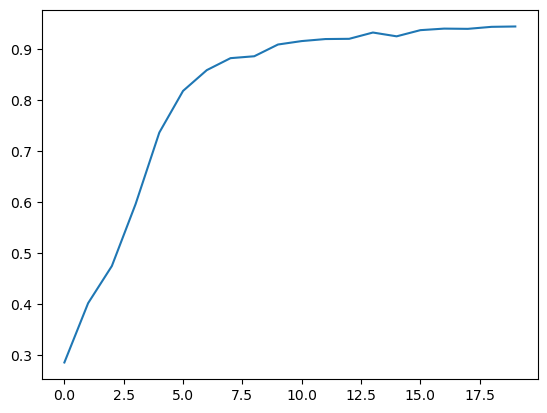

In [30]:
sns.lineplot(SignTraffic.history['accuracy'])

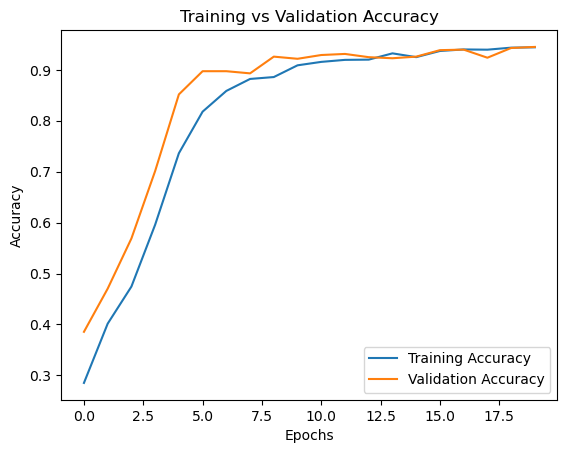

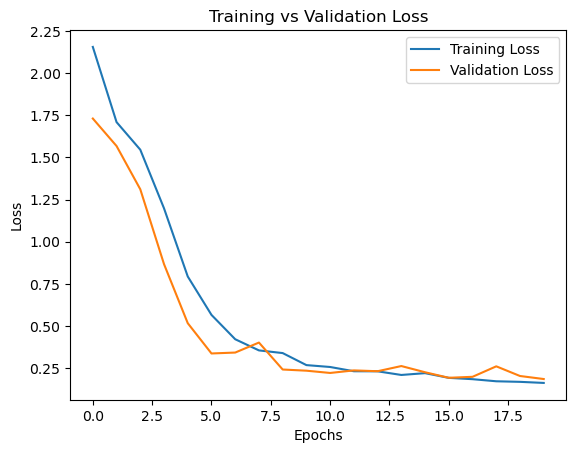

In [31]:
# Assuming history is the result of the model's fit() method
plt.plot(SignTraffic.history['accuracy'], label='Training Accuracy')
plt.plot(SignTraffic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(SignTraffic.history['loss'], label='Training Loss')
plt.plot(SignTraffic.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<a id="evaluation"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 6 |Evaluation</p>

<a id="confusion-matrix"></a>
# <b><span style='color: black; font-size: 80%;'>Step 6.1 |</span><span style='color: black; font-size: 80%;'> Confusion Matrix </span></b>


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


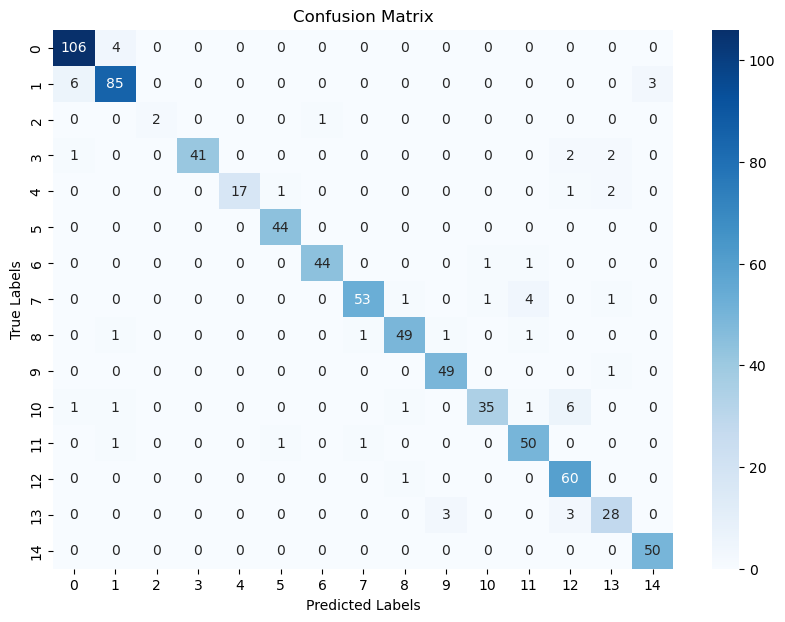

In [34]:
test_predictions = cnnModel.predict(test_data_features)
test_predictions = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

<a id="performance-metrics"></a>
# <b><span style='color: black; font-size: 80%;'>Step 6.2 |</span><span style='color: black; font-size: 80%;'> Performance Metrics</span></b>

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  
    fn = cm[i, :].sum() - tp 
    tn = cm.sum() - (tp + fp + fn)
    
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 106
False Positive (FP): 8
False Negative (FN): 4
True Negative (TN): 652
Precision: 0.9298
Recall: 0.9636
F1-Score: 0.9464
Accuracy: 0.9844

Class 1:
True Positive (TP): 85
False Positive (FP): 7
False Negative (FN): 9
True Negative (TN): 669
Precision: 0.9239
Recall: 0.9043
F1-Score: 0.9140
Accuracy: 0.9792

Class 2:
True Positive (TP): 2
False Positive (FP): 0
False Negative (FN): 1
True Negative (TN): 767
Precision: 1.0000
Recall: 0.6667
F1-Score: 0.8000
Accuracy: 0.9987

Class 3:
True Positive (TP): 41
False Positive (FP): 0
False Negative (FN): 5
True Negative (TN): 724
Precision: 1.0000
Recall: 0.8913
F1-Score: 0.9425
Accuracy: 0.9935

Class 4:
True Positive (TP): 17
False Positive (FP): 0
False Negative (FN): 4
True Negative (TN): 749
Precision: 1.0000
Recall: 0.8095
F1-Score: 0.8947
Accuracy: 0.9948

Class 5:
True Positive (TP): 44
False Positive (FP): 2
False Negative (FN): 0
True Negative (TN): 724
Precision: 0.9565
Recall: 1.0000
F1-Score: 0.977

In [37]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       110
           1       0.92      0.90      0.91        94
           2       1.00      0.67      0.80         3
           3       1.00      0.89      0.94        46
           4       1.00      0.81      0.89        21
           5       0.96      1.00      0.98        44
           6       0.98      0.96      0.97        46
           7       0.96      0.88      0.92        60
           8       0.94      0.92      0.93        53
           9       0.92      0.98      0.95        50
          10       0.95      0.78      0.85        45
          11       0.88      0.94      0.91        53
          12       0.83      0.98      0.90        61
          13       0.82      0.82      0.82        34
          14       0.94      1.00      0.97        50

    accuracy                           0.93       770
   macro avg       0.94      0.90      0.91       770
weighted avg       0.93   

<a id="serialization"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 7 |Model Serialization</p>

In [39]:
cnnModel.save("models/model.keras")

<a id="inference"></a>
# <p style="font-family:calibri; color: black; font-size:100%; text-align:center; border-radius:15px 50px; margin-bottom: 0px;">Step 8 |Inference </p>

In [41]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    img = Image.open(image_path)
    print(f"Original Image Size: {img.size}")
    img = img.resize((90, 90))
    img_array = np.array(img)
    if len(img_array.shape) == 2: 
        img_array = np.stack([img_array] * 3, axis=-1)
    
    img_array = img_array / 255.0
    img_array = img_array.reshape(-1, 90, 90, 3)
    print(f"Image Resize: {img_array.shape}")
    return img_array

In [42]:
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)   
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_probability = np.max(predictions, axis=1)[0]
    return predicted_class, predicted_probability

Original Image Size: (217, 237)
Image Resize: (1, 90, 90, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Class: 8
Prediction Probability: 1.0000


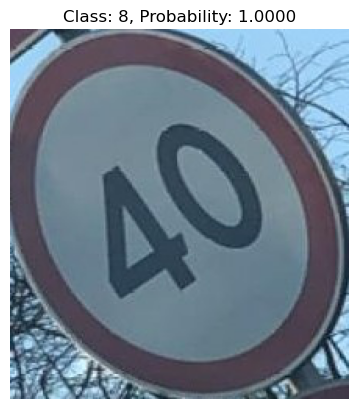

In [43]:
# Example usage
test_path = r"test_img\40_louta_2.jpg" 
expected_size=(90, 90)
predicted_class, predicted_probability = predict_image(test_path, cnnModel)
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probability: {predicted_probability:.4f}")
img = Image.open(test_path)
plt.imshow(img)
plt.axis('off')  
plt.title(f"Class: {predicted_class}, Probability: {predicted_probability:.4f}")
plt.show()